In [1]:
import os
import gc
import h5py

from pathlib import Path
from datetime import datetime
from tqdm.notebook import tqdm

import numpy as np
from scipy.special import expit

import matplotlib.pyplot as plt
import matplotlib as mpl

from pde import MemoryStorage, PDEBase, FieldCollection, ScalarField, VectorField, CartesianGrid

from methods import generate_combinations, generate_rand_k
from models import Unstable_Two_Phase_Gas_Grav

In [ ]:
vhole_massive_calc_params = {                              
                            # параметры модели
                            'shape' : (16, 80, 4), # точки, (x, y, z) y - вертикаль, отсчитывается снизу: y[0] - дно
                            'sides' : ((0, 4), (0, 16), (0, 1)), # размеры в метрах, от и до, по каждой размерности

                            # геометрия области с гидратом
                            'H' : 10, # глубина верхней границы гидратов, от поверхности дна, метры
                            'b' : 4, # толщина области разложения газогидрата, метры

                            # параметры среды
                            'k' : [1, 0.1, 0.01, 0.001], # проницаемость
                            'm' : 0.4, # пористость 

                            # к-т Диффузии
                            'D' : [5e-10, ], # целевое значение 0.5у-5 см2/c = 5e-10 м2/с

                            # Давления
                            'P0' : 0.13, # MPa давление на нулевой глубине: 3 метра столба плюс атмосфера = 0.1 + 0.03 Мпа
                            'Pc' : [0.0008, 0.08], # МPа капиллярное давление, Pc = 2*alpha/r alpha - коэффициент пов. нат., r - характерный размер пор.
                            # Pc = 2*alpha/r alpha - коэффициент пов. нат., r - характерный размер пор. можно оценить r~sqrt(k/m)
                            # в статье Атмосфер брали r=0.08 мм (модельная среда Чувилина?) то Pc = 1000 Ньютон/м2 = 1000 Паскалям = 0.001 МПа
                            # Pc = 2*0.04/(r*1e-3)*1e-6 # MPa

                            # В статье Чувилина за 25й год состав модельной среды - песок плюс глина,
                            # у песка максимум распределеия частиц 0.25-0.1 мм у глинки 0.001
                            # отсюда два значения Pc на выбор: 0.0008 и 0.08 МПа

                            # начальная насыщенность
                            's0' : 0.05, # во всей области
                            's_star' : 0.25, # миниммальная подвижная насыщенность 
                            's_gas' : 0.25, # начальная насыщенность в области с газом (почти равна s_sta чтобы не ждать, когда газ до неё докопится)

                            # распределённый источник газа 
                            'q' : [1e-6, 1e-7, 1e-8],  # это m*d(s*ro)/dt, если выделение массы газа в единице объёма (в 1 кг куб. метре) в секунду, то q=1 кг/м3*сек
                            
                            # прочие параметры моделирования чтобы два раза не сохранять
                            'timestep' : 3600, # шаг сохранения в секундах
                            't_range' : 3600*24*30, # сколько секунд считать

                            's_eps': 0.01
                            }

vhole_massive_params_list = generate_combinations(vhole_massive_calc_params) # генерим комбинации параметров

# один раз сгенерировать проницаемость
temp_eq = Unstable_Two_Phase_Gas_Grav(**vhole_massive_params_list[0]) # закостылено
rand_k = generate_rand_k(temp_eq)
np.save('layered_k', rand_k)
rand_k = np.load('layered_k.npy')

exp_name = 'del_me_exp' 

CURR_DIR = os.getcwd()
dir_path = Path(f'{CURR_DIR}/results_{exp_name}___{datetime.now().strftime("%d_%m_%Y__%H_%M_%S")}')
dir_path.mkdir(parents=True, exist_ok=True)

for run_idx, params in enumerate(vhole_massive_params_list):

    # само моделирование
    eq = Unstable_Two_Phase_Gas_Grav(**params)
    k_field = ScalarField(eq.grid, data=rand_k)
    eq.k_field = k_field

    ini_state = FieldCollection([eq.p_ini_field, eq.s_ini_field])
    storage = MemoryStorage()

    res = eq.solve(ini_state, t_range=eq.t_range, adaptive=True, tracker=['progress', 'plot', storage.tracker(eq.timestep)])
    press, sat = np.array(storage.data)[:,0,...],  np.array(storage.data)[:,1,...]

    # сохранение резов
    run_path = Path(os.path.join(dir_path, f'run_{run_idx}__s_star={params['s_star']}__Date_{datetime.now().strftime("%d-%m-%Y_%H-%M-%S")}'))
    run_path.mkdir(parents=True, exist_ok=True)\
    
    press_path = os.path.join(run_path, 'press')
    np.save(press_path, press)

    sat_path = os.path.join(run_path, 'sat')
    np.save(sat_path, press)
    
    # приборка
    storage.clear()
    del press, sat
    gc.collect()

  0%|          | 0/8640000.0 [00:00<?, ?it/s]

Output()

In [76]:
eq = Unstable_Two_Phase_Gas_Grav()

'''
Считаем возможность возникновение выброса
'''
# dir_path = 'results_3D_for_dd_d5e-10_q1e-7___10_29_2024__01_50_21'
# dir_path =  'results_3D_for_dd_d1e-9_q1e-7___10_31_2024__03_48_22'
# dir_path =  'results_3D_for_dd_d3e-9_q1e-7___10_31_2024__21_08_31'
# dir_path =  'results_3D_for_dd_d5e-9_q1e-7___10_29_2024__20_23_26'
# dir_path = 'test_cell_size_dd_d3e-9_q1e-7___11_01_2024__16_31_49'


P_gas = np.load(f'{dir_path}/press.npy')
s = np.load(f'{dir_path}/sat.npy')

liq_ro_g_h =  eq.get_ro_g_h(eq.ro_liq) + eq.P0 # началльное давление в воде (гидростатика, прибавляем давление столба воды сверху дна)
solid_ro_g_h = eq.get_ro_g_h(eq.ro_solid) + eq.P0 # литостатика

P_liq = np.max((P_gas - eq.Pc, np.ones_like(P_gas)*liq_ro_g_h), axis=0) # давление в воде с учётом текуущего давления газа (либо гидростатика, либо давление газа минус капиллярное давление, смотря что болше)

'''
Критерий выброса - превышение порового давления над литостатикой.
Поровое давление предлагаю считать среднее между газом и жидкостью с весом насыщенностию
Ну то есть если есьт некий объём среды, часть которого занята газом, а часть жидкостью, 
то на скелет действует давление газа там где газ, и жидкости там, где жидкость, пропорционально их долям, а это иесть насыщенность.
Как на самом деле надо считать - мне не очень непонятно. В реальности вода смачивает скелет, то есть он контактирует только с водой. 
Но в концепции фазовых проницаемостей мы считаем, что флюиды каждый по отдельности взаимодействуют только со скелетом, а не между собой, 
поэтому мы можем применять дари для каждой из фаз.
Вобщем тут вопрос философский. 
'''
sigma = 0.005 # сигма разницы порового и литостатики, при которых начнётся разрушение, МПа
# pore_press = s * P_gas + (1-s) * P_liq # средневзвешенное поровое давление
pore_press =  P_liq # давление жидкости

# вероятность возникновения разрушения
fracture_prob = expit((pore_press - solid_ro_g_h)/sigma) # логистичекая сигмоида от отношения порового и литостатики, чтобы вероятность на графике была красивее
'''
expit(x) = 1/(1+exp(-x))
expit(0) = 0.5
expit(3) = 0.95
то естсь при отношении порового и литостатики, равного 1 вероятность 0.5, а при разнице плюс мину 3 сигма вероятность будет от 0.05 до 0.95 примерно:

Пример для понимания - 
sigma = 0.02
x = np.linspace(0,2,100)
fr_prob = expit((x-1)/(sigma))

fig, ax = plt.subplots()
ax.plot(x, fr_prob )
'''
pass

In [ ]:
# funcs for plotting results

def plot_press(eq, data, mask=None, vmin_vmax=None, save=False, title=None, fname='gas_pore_pressure'):
    cmap = mpl.cm.viridis
    if vmin_vmax is None:
        norm = mpl.colors.Normalize(vmin=np.min(data), vmax=np.max(data))
    else:
        norm = mpl.colors.Normalize(vmin=vmin_vmax[0], vmax=vmin_vmax[1])
        # norm = mpl.colors.LogNorm(vmin=vmin_vmax[0], vmax=vmin_vmax[1])

    x_ax, y_ax, z_ax = (np.linspace(s[0], s[1], sh) for sh, s in zip(eq.shape, eq.sides))  # km

    fig, ax = plt.subplots(figsize=(3, 4), layout="constrained")

    ax.imshow(data[:, :, 0].transpose(), extent=[x_ax[0], x_ax[-1], y_ax[-1], y_ax[-0]], origin='lower', cmap=cmap, norm=norm)

    if mask is not None:
        ax.imshow(mask[:, :, 0].transpose(), extent=[x_ax[0], x_ax[-1], y_ax[-1], y_ax[-0]], origin='lower', cmap="cool", alpha=mask[:, :, 0].transpose()) # mask

    if title:
        ax.set_title(title)
    else:
        ax.set_title('XZ plane')

    ax.set_xlabel('x, m')
    ax.set_ylabel('Depth, m')

    # колорбар
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                ax=ax, orientation='vertical', label='Pore pressure, MPa')

    if save:
        plt.savefig(f'{fname}.png', dpi = 300,  bbox_inches='tight', transparent=False)

    # plt.show()
    plt.close()


def plot_sat(eq, data, mask=None, vmin_vmax=None,  cmap=None, save=False, title=None, fname='gas_saturation'):

    if cmap is not None:
        cmap = cmap
    else:
        cmap = mpl.cm.viridis

    if vmin_vmax is None:
        norm = mpl.colors.Normalize(vmin=np.min(data), vmax=np.max(data))
    else:
        norm = mpl.colors.Normalize(vmin=vmin_vmax[0], vmax=vmin_vmax[1])
        # norm = mpl.colors.LogNorm(vmin=vmin_vmax[0], vmax=vmin_vmax[1])

    x_ax, y_ax, z_ax = (np.linspace(s[0], s[1], sh) for sh, s in zip(eq.shape, eq.sides))  # km

    fig, ax = plt.subplots(figsize=(3, 4), layout="constrained")

    ax.imshow(data[:, :, 0].transpose(), extent=[x_ax[0], x_ax[-1], y_ax[-1], y_ax[-0]], origin='lower', cmap=cmap, norm=norm)

    if mask is not None:
        ax.imshow(mask[:, :, 0].transpose(), extent=[x_ax[0], x_ax[-1], y_ax[-1], y_ax[-0]], origin='lower', cmap="cool", alpha=mask[:, :, 0].transpose()) # mask

    if title:
        ax.set_title(title)
    else:
        ax.set_title('XZ plane')
    ax.set_xlabel('x, m')
    ax.set_ylabel('Depth, m')

    # колорбар
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                ax=ax, orientation='vertical', label='Gas saturation')

    if save:
        plt.savefig(f'{fname}.png', dpi = 300,  bbox_inches='tight', transparent=False)

    # plt.show()
    plt.close()


def plot_fracture_prob(eq, data,  mask=None, vmin_vmax=None, save=False, title=None, fname='fracture_prob'):
    cmap = mpl.cm.plasma

    norm = mpl.colors.Normalize(vmin=0, vmax=1)

    x_ax, y_ax, z_ax = (np.linspace(s[0], s[1], sh) for sh, s in zip(eq.shape, eq.sides))  # km

    fig, ax = plt.subplots(figsize=(3, 4), layout="constrained")

    to_plot = data[:, :, 0].transpose()

    ax.imshow(to_plot, extent=[x_ax[0], x_ax[-1], y_ax[-1], y_ax[-0]], origin='lower', cmap=cmap, norm=norm)
    
    # plot fracture
    if mask is not None:
        ax.imshow(mask[:, :, 0].transpose(), extent=[x_ax[0], x_ax[-1], y_ax[-1], y_ax[-0]], origin='lower', cmap="cool", alpha=mask[:, :, 0].transpose()) # mask

    if title:
        ax.set_title(title)
    else:
        ax.set_title('XZ plane')
    ax.set_xlabel('x, m')
    ax.set_ylabel('Depth, m')

    # колорбар
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                ax=ax, orientation='vertical', label='Fracture probability')

    if save:
        plt.savefig(f'{fname}.png', dpi = 300,  bbox_inches='tight', transparent=False)

    # plt.show()
    plt.close()


def plot_press_curves(eq, press, save=False, fname='pressure_curves'):
    steps = press.shape[0]
    fig, ax = plt.subplots(figsize=(4, 4))
    cmap = mpl.cm.viridis
    norm = mpl.colors.Normalize(vmin=0, vmax=steps/3600)

    _ , y_ax, _ = (np.linspace(s[0], s[1], sh) for sh, s in zip(eq.shape, eq.sides))
    depth = np.flip(y_ax)

    ax.invert_yaxis()
  
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                ax=ax, orientation='horizontal', location='top', label='Time, h')

    ax.set_xlabel('Liquid Pressure, MPa')
    ax.set_ylabel('Depth, m')

    for ii in tqdm(range(steps)):
        hh = ii /3600
        if ii%10 == 0:
          mean_data = np.mean(press[ii], axis = (-3, -1))
          l1, = ax.plot(mean_data, depth, color=cmap(norm(hh)))

    solid_ro_g_h = eq.get_ro_g_h(eq.ro_solid) + eq.P0 # литостатика
    lith = np.mean(solid_ro_g_h, axis = (-3, -1))
    l2, = ax.plot(lith, depth, color='r', linestyle = ':')

    ax.legend([l1, l2], ['Liquid Pressure', 'Lithostatic Pressure'])

    if save:
        plt.savefig(f'{fname}.png', dpi = 300,  bbox_inches='tight', transparent=False)

    plt.show()
    plt.close()
    

def plot_sat_curves(eq, sat, save=False, fname='sat_curves'):
    steps = sat.shape[0]
    fig, ax = plt.subplots(figsize=(3, 4))
    cmap = mpl.cm.viridis
    norm = mpl.colors.Normalize(vmin=0, vmax=steps * eq.t_scale/3600)

    _ , y_ax, _ = (np.linspace(s[0], s[1], sh) for sh, s in zip(eq.shape, eq.sides))
    depth = np.flip(y_ax)

    ax.invert_yaxis()
  
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                ax=ax, orientation='horizontal', location='top', label='Time, h')

    ax.set_xlabel('Gas Saturation')
    ax.set_ylabel('Depth, m')

    for ii in tqdm(range(steps)):
        hh = ii * eq.t_scale/3600
        if ii%10 == 0:
          mean_data = np.mean(sat[ii], axis = (-3, -1))
          l1, = plt.plot(mean_data, depth, color=cmap(norm(hh)))

    ax.legend([l1,], ['Gas Saturation',])

    if save:
        plt.savefig(f'{fname}.png', dpi = 300,  bbox_inches='tight', transparent=False)

    # plt.show()
    plt.close()
    

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

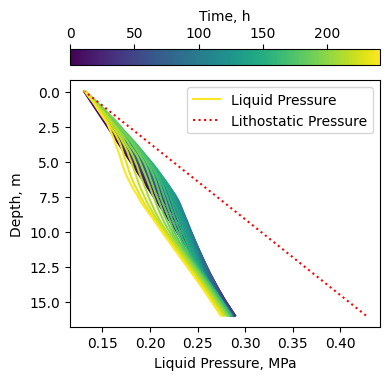

  0%|          | 0/241 [00:00<?, ?it/s]

In [ ]:
# pics for gifs
P_gas = np.load(f'{dir_path}/press.npy')
s = np.load(f'{dir_path}/sat.npy')

# create some folders
pic_path = Path(f'{dir_path}/pics/')

press_path = Path(f'{dir_path}/pics/press/')
press_path.mkdir(parents=True, exist_ok=True)

sat_path = Path(f'{dir_path}/pics/sat/')
sat_path.mkdir(parents=True, exist_ok=True)

prob_path = Path(f'{dir_path}/pics/fr_prob/')
prob_path.mkdir(parents=True, exist_ok=True)

# common vmin vmax
press_vmin_vmax=(np.min(P_gas), np.max(P_gas))
# sat_vmin_vmax=(np.min(s), np.max(s))
sat_vmin_vmax=(0, 0.25)

for ii in tqdm(range(P_gas.shape[0])):

    tt = ii /3600 # hours
    
    mask = (fracture_prob[ii]>=0.5).astype('float')
    mask = None
     
    plot_press(eq, P_gas[ii], mask=mask, vmin_vmax = press_vmin_vmax, title=f'T = {tt} h', save=True, fname=f'{press_path}/press_{ii}')
    plot_sat(eq, s[ii], mask=mask, vmin_vmax = sat_vmin_vmax, title=f'T = {tt} h', save=True, fname=f'{sat_path}/sat_{ii}')
    plot_fracture_prob(eq, fracture_prob[ii], mask=mask, title=f'T = {tt} h', save=True, fname=f'{prob_path}/fr_prob_{ii}')

plot_press_curves(eq, P_gas - eq.Pc, save=True, fname=f'{pic_path}/press_curves') 
plot_sat_curves(eq, s, save=True, fname=f'{pic_path}/sat_curves')

### Дальше всякие рабочие моменты для тестирования, не для публикации

In [ ]:
'''  
Конвертим проницаемсть в размер и капиллярное давление
'''

def d_to_k(d_mm: float, m=0.4) -> float:
    """
    Пермеабельность k [Darcy] из размера зёрен d [мм] по Козени-Кармену.
    """
    DARCI_TO_M2 = 9.869233e-13          #   1 Darcy  → м²
    d_m = d_mm * 1e-3                                     # мм → м
    k_m2 = (m**3 * d_m**2) / (180 * (1 - m)**2)       # базовая Kозени-Карман-формула
    return k_m2 / DARCI_TO_M2                         # м² → Darcy

def k_to_d(k_darcy: float, m=0.4) -> float:
    """
    Размер зёрен d [мм] из проницаемости k [Darcy] по Козени-Кармену.
    """
    DARCI_TO_M2 = 9.869233e-13          #   1 Darcy  → м²
    k_m2 = k_darcy * DARCI_TO_M2                          # Darcy → м²
    d_m  = np.sqrt(k_m2 * 180 * (1 - m)**2 / m**3)   # обратная KC-формула
    return d_m * 1e3  # мм

def r_to_Pc(d_mm: float, alpha=0.04):
    Pc = 2*alpha/(d_mm*1e-3)*1e-6 # MPa
    return Pc

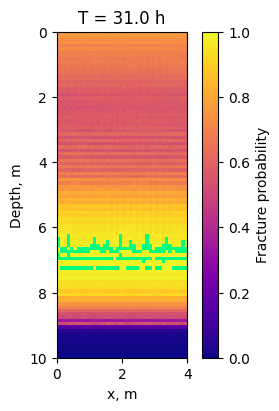

In [144]:

plot_fracture_prob(eq, fracture_prob[105], title=f'T = {tt} h', save=True, fname=f'{fpath}/fr_p_{ii}')

In [ ]:
yield_path = 'delete_me.h5' # saving
with h5py.File(yield_path, 'w') as targ:
    perm_h5_set = targ.create_dataset("press",  data=press) # 
    dens_h5_set = targ.create_dataset("s",  data=sat)   

In [73]:
# генерируем слоистую проницаемость
def generate_and_save_k_field(eq, alpha=0.001):
    rand_k = np.ones(eq.shape) * eq.k
    rand_k[:,3:-3,:]  = rand_k[:,3:-3,:] + alpha * np.random.randn(*(rand_k[:,3:-3,:].shape)) * eq.k 
    lines = np.random.randn(1, rand_k.shape[1], 1)
    rand_k = rand_k * (1 + alpha*(lines))
    return rand_k

# один раз сгенерировать проницаемость
eq = Unstable_Two_Phase_Gas_Grav()
rand_k = generate_and_save_k_field(eq)
np.save('layered_k', rand_k)

# и потом подставлять её в уравнение для каждого расчёта
# eq = Unstable_Two_Phase_Gas_Grav()
# rand_k = np.load('layered_k.npy')
# k_field = ScalarField(eq.grid, data=rand_k)
# eq.k_field = k_field


In [7]:
# генерируем слоистую проницаемость для 2D
def generate_and_save_k_field_2D(eq, alpha=0.1):
    rand_k = np.ones(eq.shape) * eq.k
    rand_k[:,3:-3]  = rand_k[:,3:-3] + alpha * np.random.randn(*(rand_k[:,3:-3].shape)) * eq.k 
    # lines = np.random.randn(1, rand_k.shape[1], 1)
    # rand_k = rand_k * (1 + alpha*(lines))
    return rand_k

# один раз сгенерировать проницаемость
eq = Unstable_Two_Phase_Gas_Grav_2D()
rand_k = generate_and_save_k_field_2D(eq)
np.save('layered_k', rand_k)

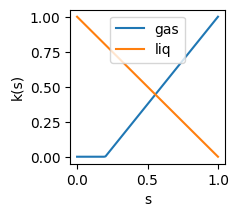

In [42]:
def k_s_gas(s):

    s_star = 0.2
    k = (s-s_star)/(1-s_star)
    k[s < s_star] = 0
    return k

s = np.linspace(0,1,100)
fig, ax = plt.subplots(figsize=(2, 2))
ax.plot(s, k_s_gas(s), label='gas')
ax.plot(s, 1-s, label='liq')
ax.set_xlabel('s')
ax.set_ylabel('k(s)')
ax.legend()

### 2d


In [ ]:
class Unstable_Two_Phase_Gas_Grav_2D(PDEBase):
  
    def __init__(self):
        super().__init__()
        self.s_eps = 0.001  # минимально возможная газонасыщенность
        self.shape = (40, 160) # points
        self.sides = ((0, 4), (0, 16)) # meters
        self.t_scale = 3600 # sec - масштаб времени
        
        self.O = (2, 3.5) # центр области с газогидратом, метры
        self.R0 = 2.5 # радиус области разложения газогидрата, метры
         
        # параметры среды
        self.k = 0.1 # Darcy проницаемсть
        self.m = 0.4 # поистость

        # параметры флюидов
        self.ro_gas = 1.28 # начальная плотность газа kg/m3
        self.ro_liq = 1000 # плотность жидкоти kg/m3
        self.ro_solid = 1900 # плотность грунта kg/m3

        self.nu_gas = 0.01 / self.t_scale # вязкость газа cP
        self.nu_liq = 1 / self.t_scale # вязкость жидкости cP

        # эффективный коэффициент диффузии для газа
        '''
        Iversen, N., and Jørgensen, B. B. (1993). Diffusion coefficients of sulfate and
        methane in marine sediments: Influence of porosity. Geochim. Cosmochim. Acta 57
        (3), 571–578. doi: 10.1016/0016-7037(93)90368-7
        '''
        self.D = 1e-8 * self.t_scale

        # давление
        self.P0 = 0.13 # MPa press - давление на нулевой глубине - 20 метров = 0.1 + 0.2 Мпа
        self.P_gas = 0.0 # MPa давление в газовой области (превышение над гидростатическим)
        self.Pc = 0.001 # МPа капиллярное давление, Pc = 2*alpha/r alpha - коэффициент пов. нат., r - характерный размер пор. можно оценить r~sqrt(k/m)
        '''
        k = 1 D => r = sqrt(2) mkm => Pc = 0.056 MPa (alpha=0.04 N/m, 1 Pa = 1N/m2) 
        k = 0.1 D => Pc = 0.18 MPa 
        k = 0.01 D => Pc = 0.56 MPa 
        '''

        # начальная насыщенность
        self.s0 = 0.05 # во всей области
        self.s_star = 0.2 # миниммальная подвижная насыщенность 
        self.s_gas = self.s_star # начальная насыщенность в области с газом (почти равна s_sta чтобы не ждать, когда газ до неё докопится)

        # пороговый градиент
        self.G = 0.01 # МПа/м  - равен гидростатики например

        # распределённый источник газа 
        self.q = 1 * 1e-6 * self.t_scale # это m*d(s*ro)/dt, если выделение массы газа в единице объёма (в 1 кг куб. метре) в секунду, то q=1 кг/м3*сек

                # generate grid
        self.grid = CartesianGrid(self.sides, self.shape)  

        # выделенная область с газом
        xyz = self.grid.cell_coords # координаты сетки
        # xh, yh = np.where(self.grid.distance(xyz, self.O) <= self.R0) # координаты области с газогидратом
        xh, yh= np.where((xyz[:,:,1] <= self.O[1] + self.R0) & (xyz[:,:,1] >= self.O[1] - self.R0))
                        #  & (xyz[:,:,0] >= 2 ) & (xyz[:,:,0] <= 6 )) # координаты области с газогидратом

        # поле проницаемости со случайными вариациями 
        rand_k = np.ones(self.shape) * self.k 
        # rand_k[:,3:-3]  = rand_k[:,3:-3] + 0.2 * np.random.randn(*(rand_k[:,3:-3].shape)) * self.k 
        self.k_field = ScalarField(self.grid, data=rand_k)

        # g field  - поле силы тяжести
        g = np.zeros((2,) + self.shape) # 
        g[1,:] = - 9.81 * 1e-6 # gravity by Y ax; 1e-6 - to be good with pressire in MPa
        self.g_field = VectorField(self.grid, data=g) # grav field

        # hydrostatic field - гидростатическое поле давления
        self.ro_g_h = self.get_ro_g_h(self.ro_liq)

        # Pore initial field - начальное поровое давление газа
        P_ini = np.ones(self.shape) * self.ro_g_h + self.P0 + self.Pc # давление во всём объёме
        P_ini[xh, yh] = P_ini[xh, yh] + self.P_gas # давлеие в области с газом 
        self.p_ini_field = ScalarField(self.grid, data=P_ini) # MPa

        # s_gas initial field - начальное поле насыщенности газом
        s_ini = np.ones(self.shape) * self.s0 # насыщенность во всём объёме
        s_ini[xh, yh] = self.s_gas # насыщенность в области с газом 
        
        self.s_ini_field = ScalarField(self.grid, data=s_ini) 

        # source field - распределённый источник газа. q по сути это dro/dt в области выделения, если выделение газа 1 кг в куб. метре в секунду, то q=1 кг/м3*сек
        q = np.zeros(self.shape)
        q[xh, yh] = self.q 
        self.source_field = ScalarField(self.grid, data=q) 

        # boundary condition
        ro_g = 9.81 * 1e-6 * self.ro_liq
        # self.p_gas_bc = [{'derivative': 0}, [{'derivative': ro_g}, {'value':self.p_ini_field.data[:,-1]}]]
        # self.ro_gas_bc = [{'derivative': 0}, [{'derivative': self.ro(ro_g)}, {'value':self.ro(self.p_ini_field.data[:,-1])}]]

        self.p_gas_bc = [ [{'value':self.p_ini_field.data[0,:]}, {'value':self.p_ini_field.data[-1,:]}],
                          [{'value':self.p_ini_field.data[:,0]}, {'value':self.p_ini_field.data[:,-1]}], 
                          ]
     

    # метод для вычисления гидростатического давления, плотность должна быть в кг/м3
    def get_ro_g_h(self, ro):
        ro_g = self.g_field.to_scalar().data * ro * self.grid.cell_volume_data[1] 
        ro_g_h = np.cumsum(ro_g, axis=1) - ro_g/2 # гидростатическое давление, среднее по ячейке, поэтому минус половина ro_g
        ro_g_h = np.flip(ro_g_h, axis=1) # Y направлена снизу вверх
        return ro_g_h

    # относительные фазовые проницаемости: 
    # для газа
    def k_s_gas(self, s, ks_min=0):
        sd = s.data
        ks = (sd-self.s_star)/(1-self.s_star)
        ks[ks < ks_min] = ks_min
        return ScalarField(self.grid, data=ks)
    
    # # для жидкости
    def k_s_liq(self, s):
        return s # просто s, смачивающая фаза
    
    # для жидкости
    # def k_s_liq(self, s):
    #     sd = s.data
    #     s_star = np.ones_like(sd) * self.s_star # минимальная подвижная насыщенность, при меньшей проницаемость ks_min, при большей - линейная
    #     ks = sd/(1 - s_star)
    #     ks[ks > 1] = 1
    #     return ScalarField(self.grid, data=ks)
          
    # уравнение состояния для газа
    def P(self, ro):
        P = ro * 0.1 / self.ro_gas # 0.1 МПа
        return P
    
    def ro(self, P):
        ro = P * self.ro_gas / 0.1
        return ro    

    def get_P_liq(self, P_gas):
        return P_gas - self.Pc
        
    def check_ds_dt(self, s_field, ds_dt_field):
        s = s_field.data
        ds_dt = ds_dt_field.data
        
        ds_dt[(s <= self.s_eps) & (ds_dt < 0 )] = 1e-8
        ds_dt[(s >= 1 - self.s_eps) & (ds_dt > 0 )] = -1e-8
            
        return ScalarField(self.grid, data=ds_dt)

    
    # def check_dro_dt(self, ro_field, dro_dt_field):
    #     ro = ro_field.data
    #     dro_dt = dro_dt_field.data
            
    #     dro_dt[(ro <= self.ro(self.P0)) & (dro_dt < 0 )] = 1e-8
            
    #     return ScalarField(self.grid, data=dro_dt)
    
    # вся магия тут
    def evolution_rate(self, state, t=0):
        ''' Basniev pp.256'''
        P_gas, s_gas = state # искомые поля - давление и насыщенность газом
        # s_gas = self.check_s(s_gas) # на всякий случай обрезаем насыщенность, чтобы не выходила за границы разумного
        
        s_liq = 1-s_gas # насыщенность жидкости = 1 - s газа

        ro = self.ro(P_gas) # распреджеление плотности газа исходя из давления

        kk_gas = (1e-3 * self.k_field / self.nu_gas) * self.k_s_gas(s_gas) # то, на что умножается градиент в законе Дарси
        kk_liq = (1e-3 * self.k_field / self.nu_liq) * self.k_s_liq(s_liq)

        # градиент от этого (просто проницаемость за скобку для стабильности)
        grad_kk_gas = (1e-3 * self.k_field / self.nu_gas) * self.k_s_gas(s_gas).gradient({'derivative': 0}) 
        grad_kk_liq = (1e-3 * self.k_field / self.nu_liq) * self.k_s_liq(s_liq).gradient({'derivative': 0})

        grad_P_gas = P_gas.gradient(self.p_gas_bc) 
        grad_P_liq = grad_P_gas

        laplace_P_gas = P_gas.laplace(self.p_gas_bc) # лаплас, градиент ro*g равен нулю
        laplace_P_liq = laplace_P_gas     

        div_w1 = - kk_gas * laplace_P_gas - (grad_P_gas - ro * self.g_field) @ grad_kk_gas # дивергенция от закона Дарси по правиду дивергенции произведения скалярного и векторного поля
        div_w2 = - kk_liq * laplace_P_liq - (grad_P_liq - self.ro_liq * self.g_field) @ grad_kk_liq
        
        # w1 = - kk_gas * grad_P_gas
        # div_ro_w1 = ro.gradient(self.ro_gas_bc) @ w1 + ro * div_w1

        s_diff = self.D * s_gas.laplace({'derivative': 0}) # диффузия газа, чтобы было немного ровнее с градиентом газонасыщенности       
        source = self.source_field # поле источника газа

 
        ds_gas_dt = (1/self.m) * div_w2 + s_diff # уравнение на изменение насыщенности 
        ds_gas_dt = self.check_ds_dt(s_gas, ds_gas_dt) # регуляризация производной насыщенности, чтобы за границы не выходила
        
        dro_dt = (s_gas * self.m)**-1 * (source - ro * (div_w1 + div_w2)) # пьезопроводность (относительно плотности газа)
        # dro_dt = (self.s_star * self.m)**-1 * (source - ro * (div_w1 + div_w2)) # пьезопроводность (относительно плотности газа)
        # dro_dt = (self.s_star * self.m)**-1 * (source - ro * div_w2 - div_ro_w1) # пьезопроводность (относительно плотности газа)
        # dro_dt = self.check_dro_dt(ro, dro_dt)
        
        dP_dt = self.P(dro_dt) # переводим изменение плотности в изменение давления

        return FieldCollection([dP_dt, ds_gas_dt])

## ячейка для исследования причин, почему все рушится, нужно позже удалить

In [ ]:
# to continue from prev state
# dir_path='results_3D_test___10_04_2024__16_28_25'
P_gas = np.load(f'{dir_path}/press.npy')
s = np.load(f'{dir_path}/sat.npy')

eq = Unstable_Two_Phase_Gas_Grav()

rand_k = np.load('layered_k.npy')
k_field = ScalarField(eq.grid, data=rand_k)
eq.k_field = k_field

# запускаем за три шага до провала
P_ini = ScalarField(eq.grid, data=P_gas[-2])
sat_ini = ScalarField(eq.grid, data=s[-2])

# P_ini = eq.p_ini_field
# some_sat =  eq.s_ini_field.data
# some_sat[18:22,63:65,:] = 0.4
# some_sat[18:22,60:63,:] = 0.02
# sat_ini = ScalarField(eq.grid, data=some_sat)

ini_state = FieldCollection([P_ini, sat_ini])
storage = MemoryStorage()

# t_tange относительно self.t_scale - масштаба времени
res = eq.solve(ini_state, t_range=240, adaptive=True, tracker=['progress', 'plot', storage.tracker(1)])
press, sat = np.array(storage.data)[:,0,...],  np.array(storage.data)[:,1,...]

# saving data
exp_name = 'test'

CURR_DIR = os.getcwd()
dir_path = Path(f'{CURR_DIR}/results_{exp_name}___{datetime.now().strftime("%m_%d_%Y__%H_%M_%S")}')
dir_path.mkdir(parents=True, exist_ok=True)
np.save(f'{dir_path}/press', press)
np.save(f'{dir_path}/sat', sat)

  0%|          | 0/240.0 [00:00<?, ?it/s]

Output()